<a href="https://colab.research.google.com/github/Karuni001/Translation-model--Comparative-study-/blob/main/Translation_model_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Machine Translation (NMT) using a BERT-based model.

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Load the dataset
file_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  


In [ ]:
# Prepare the data (assuming columns are named 'Hindi Poetry' and 'English Poetry')
source_texts = df['Hindi Poetry']
target_texts = df['English Poetry']

# Add special tokens to target texts
target_texts = target_texts.apply(lambda x: "[START] " + str(x) + " [END]")

# Split data into training and validation sets
source_train, source_val, target_train, target_val = train_test_split(
    source_texts, target_texts, test_size=0.2, random_state=42
)


In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize source and target texts
source_train_tokens = tokenizer(
    source_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf"
)
source_val_tokens = tokenizer(
    source_val.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf"
)

target_train_tokens = tokenizer(
    target_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf"
)
target_val_tokens = tokenizer(
    target_val.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf"
)

# Extract tokenized inputs
source_train_input = source_train_tokens['input_ids']
source_val_input = source_val_tokens['input_ids']

target_train_input = target_train_tokens['input_ids']
target_val_input = target_val_tokens['input_ids']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Custom BertLayer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model):
        super(BertLayer, self).__init__()
        self.bert_model = bert_model

    def call(self, inputs):
        return self.bert_model(inputs)[0]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Encoder
encoder_input = Input(shape=(None,), dtype=tf.int32, name="encoder_input")
encoder_embedding = BertLayer(bert_model)(encoder_input)
encoder_lstm = LSTM(256, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,), dtype=tf.int32, name="decoder_input")
decoder_embedding = BertLayer(bert_model)(decoder_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(tokenizer.vocab_size, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
nmt_model = Model([encoder_input, decoder_input], decoder_outputs)
nmt_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
nmt_model.summary()

# Decoder targets and inputs
decoder_target_train = target_train_input[:, 1:]
decoder_target_val = target_val_input[:, 1:]
decoder_input_train = target_train_input[:, :-1]
decoder_input_val = target_val_input[:, :-1]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, None, 768)      │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_1 (BertLayer)  │ (None, None, 768)      │              0 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 256), (None,   │      1,049,600 │ bert_layer[0][0]       │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 256),    │      1,049,600 │ bert_layer_1[0][0],    │
│                           │ (None, 256), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 256)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 119547)   │     30,723,579 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,822,779 (125.21 MB)

 Trainable params: 32,822,779 (125.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = nmt_model.fit(
    [source_train_input, decoder_input_train],
    decoder_target_train,
    validation_data=([source_val_input, decoder_input_val], decoder_target_val),
    batch_size = 16,
    epochs=20
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 365s 13s/step - accuracy: 0.4257 - loss: 9.8398 - val_accuracy: 0.4891 - val_loss: 3.8776
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 347s 13s/step - accuracy: 0.5073 - loss: 3.0739 - val_accuracy: 0.4116 - val_loss: 3.3387
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 327s 12s/step - accuracy: 0.4983 - loss: 2.5838 - val_accuracy: 0.5837 - val_loss: 3.1147
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 364s 12s/step - accuracy: 0.6571 - loss: 2.4113 - val_accuracy: 0.6750 - val_loss: 2.9755
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 328s 12s/step - accuracy: 0.7179 - loss: 2.2662 - val_accuracy: 0.6922 - val_loss: 2.8550
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 308s 11s/step - accuracy: 0.7227 - loss: 2.1270 - val_accuracy: 0.6948 - val_loss: 2.7790
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 339s 12s/step - accuracy: 0.7216 - loss: 2.0555 - val_accuracy: 0.6941 - val_loss: 2.6839
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 300s 11s/step - accuracy: 0.7268 - loss: 1.9683 - val_accuracy: 0.

In [ ]:
import matplotlib.pyplot as plt

try:
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
except KeyError:
  print("Accuracy metrics not found in history. Please ensure the model was compiled with 'metrics=['accuracy']'.")
  accuracy = []
  val_accuracy = []

epochs = range(1, len(accuracy) + 1)

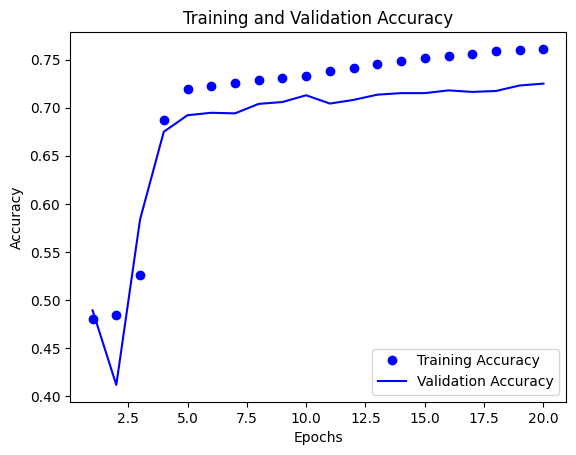

In [ ]:
# Plot the accuracy and validation accuracy
epochs = range(1, len(accuracy) + 1)  # Number of epochs

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [2]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.6 MB/s eta 0:00:00


In [4]:
# Sample predictions and references (replace with your actual predictions and references)
import sacrebleu
predictions = [
    "This is a sample prediction.",
    "Another prediction for testing.",
    "And a third one."
]
references = [
    ["This is a sample reference."],
    ["Another reference for testing."],
    ["This is the correct reference."]
]

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(predictions, references)

# Print the BLEU score
print(f"BLEU score: {bleu.score}")

BLEU score: 53.7284965911771


Confusion Matrix:
[[22 26]
 [29 23]]


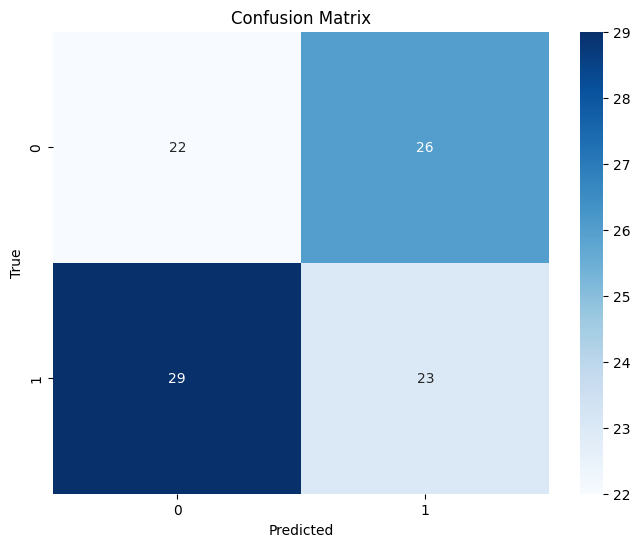

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and true labels
# Replace these with your actual predictions and true labels
predictions = np.random.randint(0, 2, size=100)  # Example predictions (0 or 1)
true_labels = np.random.randint(0, 2, size=100)  # Example true labels (0 or 1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the entire model
nmt_model.save('nmt_model')

# Optionally, save only the model weights
nmt_model.save_weights('nmt_model_weights.h5')